# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [262]:
import numpy as np
import scipy
import scipy.stats as st
from astropy.io import ascii
import matplotlib.pyplot as plt
import tqdm
import emcee
import corner

file1 = 'PS1_PS1MD_PSc000098.snana.dat'
file2 = 'PS1_PS1MD_PSc000174.snana.dat'
data1 = ascii.read('PS1_PS1MD_PSc000098.snana.dat', delimiter=' ', comment='#')
data2 = ascii.read('PS1_PS1MD_PSc000174.snana.dat', delimiter=' ', comment='#')

In [268]:
#guess of 55212 for t0 is from file 
guess1 = [10,20,55212,1000,-4,50] #general guess benchmark for *0098.snana.dat file
guess2 = [20,50,55212,300,-2,50] #general guess benchmark for *0174.snana.dat file

#defines a main function that reads file, separates into color bands, and does MCMC on each band for the file
def main(file,guess):
    data = ascii.read(file, delimiter=' ', comment='#')
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    labels = ['g','i','r','z']
    colors = ['#007f00','#f8a800','#ff0700','#84007f'] 
    masks = [data['FLT']=='g',data['FLT']=='i',data['FLT']=='r',data['FLT']=='z']
    #loop over each band within data and perform MCMC
    #plots model with median fit values as input 
    for i in range(4):
        mc = MCMC(data[masks[i]],guess)
        fdat = mc[0]
        autocorrs = mc[1]
        print('The average auto correlation for the {}-band paramters with no lag is {}.'\
              .format(labels[i],np.mean(autocorrs[0])))
        print('The average auto correlation for the {}-band paramters with a lag of 10 is {}.'\
              .format(labels[i],np.mean(autocorrs[1])))
        #fdat[2] is median fit value for t0, which was subtracted off in original paper
        ax.errorbar(data[masks[i]]['MJD']-fdat[2], data[masks[i]]['FLUXCAL'], yerr=data[masks[i]]['FLUXCALERR'],\
            linestyle='None', marker='.', color=colors[i], alpha=0.3)
        tarr = (np.linspace(data[masks[i]]['MJD'].min(), data[masks[i]]['MJD'].max(), 1000))
        ax.plot(tarr-fdat[2], model(*fdat, tarr), \
                ls='-', color=colors[i], label=labels[i])
        
    ax.set_xlim((-50,150))
    if '98' in file:
        
        ax.set_ylim((-100,1250))
    elif '174' in file:
        ax.set_ylim((-100,500))
    ax.set_xlabel('MJD-t0')
    ax.set_ylabel('Flux')
    ax.set_title(file)
    ax.legend()
    plt.show(fig1)
        
def MCMC(data,guess):
    #tr=theta[0], tf=theta[1], t0=theta[2], A=theta[3], B=theta[4], gam=theta[5] 
    
    #function for model

    def model(tr, tf, t0, A, B, gam, t):
        t1 = gam+t0
        maskA = t<t1
        output = np.zeros(len(t))
        num1 = A+B*(t[maskA]-t0)
        num2 = (A+B*gam)*np.exp(-(t[~maskA]-t1)/tf)
        den1 = (1+np.exp(-(t[maskA]-t0)/tr))
        den2 = (1+np.exp(-(t[~maskA]-t0)/tr))
        output[maskA] = num1/den1 
        output[~maskA] = num2/den2
        return np.nan_to_num(output)

    def log_likelihood(theta, *args):
        t,flux,e = args
        tr,tf,t0,A,B,gam = theta
        mod = model(tr, tf, t0, A, B, gam,t)
        lnL = ((flux - mod)**2.)/(2*e**2.)
        return np.sum(lnL)

    def nlnL(theta,*args):
        return -log_likelihood(theta,*args)




    #function for priors
    def log_priors(theta):
        tr, tf, t0, A, B,gam = theta
        if ((tr < 0.01) or (tr > 50)) or\
            ((tf < 1) or (tf > 300)) or\
            ((t0 < data['MJD'].min()) or (t0 > data['MJD'].max())) or\
            ((A < 3*np.std(data['FLUXCAL'])) or (A > 10*data['FLUXCAL'].max())) or\
            ((B < -data['FLUXCAL'].max()/150) or (B > 0)) or\
            ((gam < 0) and (gam > 150)):
            return -np.inf
        else:
            np.random.seed(10)
            #we've already checked that our paramters are within the proper ranges, so
            # we can set probabilities to be 1 (for all but gamma) due to equal uniform likelihood

            p_gam = (2/3)*st.norm.pdf(gam,loc=5,scale = 5)+(1/3)*st.norm.pdf(gam,loc=60,scale=30)

            prior = p_gam

            lprior = np.log(prior)
            return lprior

    #function for posterior
    #I do -log likelihood due to keeping it positive earlier to help with minimization
    def log_posterior(theta,*args):
        t,flux,e = args
        tr, tf, t0, A, B,gam = theta
        post = log_priors(theta) + nlnL(theta,t,flux,e)       
        return post

    def bound_gen(data):
        #tr,tf,t0,A,B,gam
        bounds = [(0.01,50),\
                  (1,300),\
                  (data['MJD'].min(),data['MJD'].max()),\
                  (10,10*data['FLUXCAL'].max()),\
                  (-data['FLUXCAL'].max()/150,0),\
                  (0,100)]
        return bounds
    
    guess = guess
    bounds = bound_gen(data)
    res=scipy.optimize.minimize(log_likelihood,guess,args=args,bounds=bounds)
    #fitvals=res.x
    sigmas = np.diag(res.hess_inv.todense())**0.5
    p0 = np.array(res.x) + 0.1*sigmas*np.random.randn(nwalkers, ndim)

    def guesses_gen(bounds):
        nwalkers = 20
        ndim = 6
        starting_guesses = np.zeros((nwalkers, ndim))
        #set guesses for normally distributed parameters
        for i in range(ndim):
            starting_guesses[:, i] = np.random.uniform(low=bounds[i][0],high=bounds[i][1],size = nwalkers)
        #set guess for last paramter (gamma)
        starting_guesses[:, -1] = (2/3)*np.random.uniform(5,5, size = nwalkers)+(1/3)*np.random.normal(60,30,size = nwalkers)
        return starting_guesses


    #run the emcee sampler finally
    def sample_gen(data):
        nwalkers = 20
        ndim = 6
        nburn = 2000  # "burn-in" period to let chains stabilize
        nsteps = 5000

        bounds = bound_gen(data)
        starting_guesses = guesses_gen(bounds)
        args = (data['MJD'],data['FLUXCAL'],data['FLUXCALERR'])

        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,\
                                         args=args )
        state = sampler.run_mcmc(p0, nburn) 
        sampler.reset()                    
        sampler.run_mcmc(state, nsteps, progress=True);
        samples = sampler.get_chain(flat=True) # you can flatten the chain - essentially concatenate the walkers
        return samples

    samples = sample_gen(data)
    #median fit values for samples
    mcmc_res = np.percentile(samples[1000::10,:], 50, axis=0)
    cplot = corner.corner(samples[1000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels);
    
    #test the auto correlation for each paramter with no lag and then with lag of 10
    p1 = np.zeros(6)
    p2 = np.zeros(6)
    for i in range(6):
        s = pd.Series(samples[:,i])
        p1[i] = s.autocorr()
        p2[i] = s.autocorr(lag=10)

    p = [p1,p2]
    return(mcmc_res,p)

/tmp/ipykernel_14835/3789072265.py:48: RuntimeWarning: overflow encountered in exp
  den1 = (1+np.exp(-(t[maskA]-t0)/tr))
/tmp/ipykernel_14835/3789072265.py:49: RuntimeWarning: overflow encountered in exp
  den2 = (1+np.exp(-(t[~maskA]-t0)/tr))
You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the g-band paramters with no lag is -0.026321805058238196.
The average auto correlation for the g-band paramters with a lag of 10 is 0.024870567624713662.


/tmp/ipykernel_14835/3789072265.py:47: RuntimeWarning: overflow encountered in exp
  num2 = (A+B*gam)*np.exp(-(t[~maskA]-t1)/tf)
/tmp/ipykernel_14835/3789072265.py:47: RuntimeWarning: overflow encountered in multiply
  num2 = (A+B*gam)*np.exp(-(t[~maskA]-t1)/tf)
/tmp/ipykernel_14835/3789072265.py:51: RuntimeWarning: invalid value encountered in divide
  output[~maskA] = num2/den2
You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the i-band paramters with no lag is -0.002564906242971692.
The average auto correlation for the i-band paramters with a lag of 10 is 0.00821678808160563.


You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the r-band paramters with no lag is -0.011943263625665439.
The average auto correlation for the r-band paramters with a lag of 10 is 0.0033114773210368895.


/tmp/ipykernel_14835/3789072265.py:58: RuntimeWarning: overflow encountered in square
  lnL = ((flux - mod)**2.)/(2*e**2.)
You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the z-band paramters with no lag is -0.08993440472205111.
The average auto correlation for the z-band paramters with a lag of 10 is -0.10804945491610862.


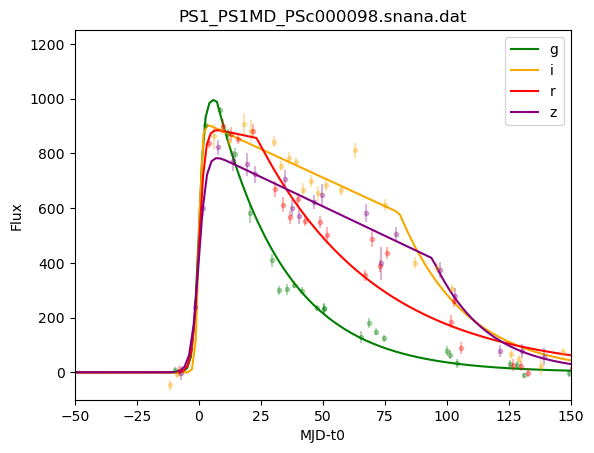

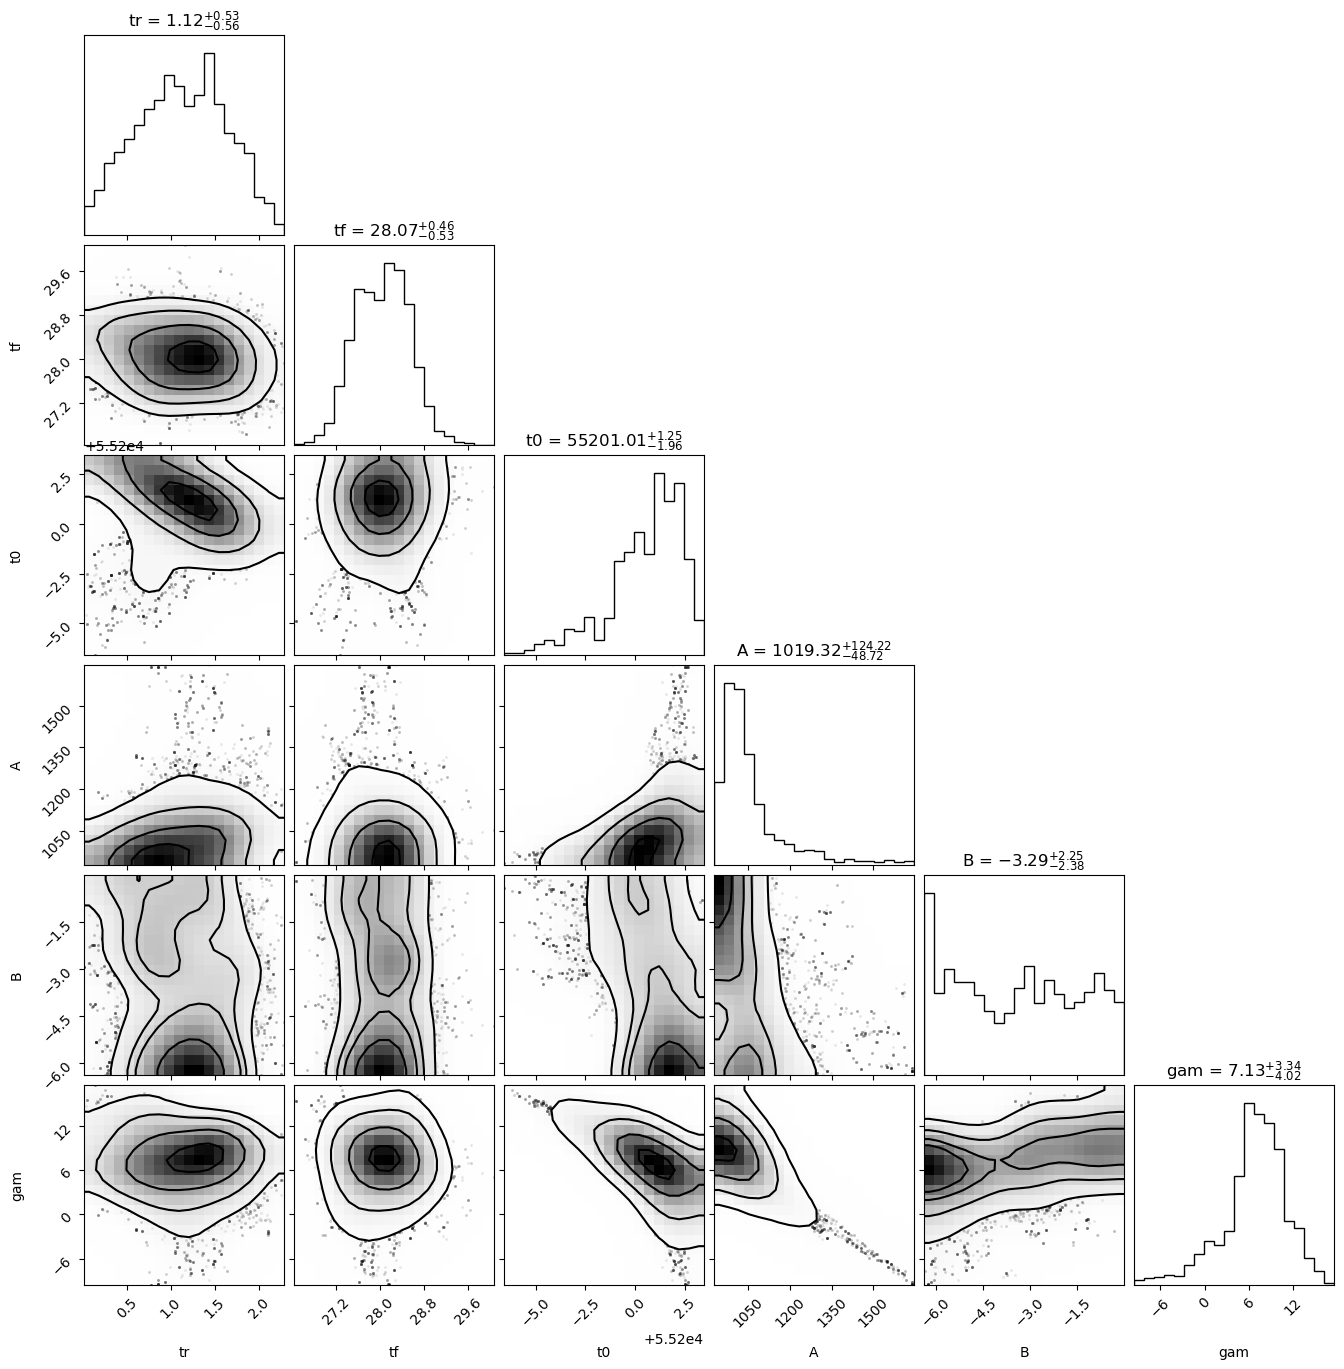

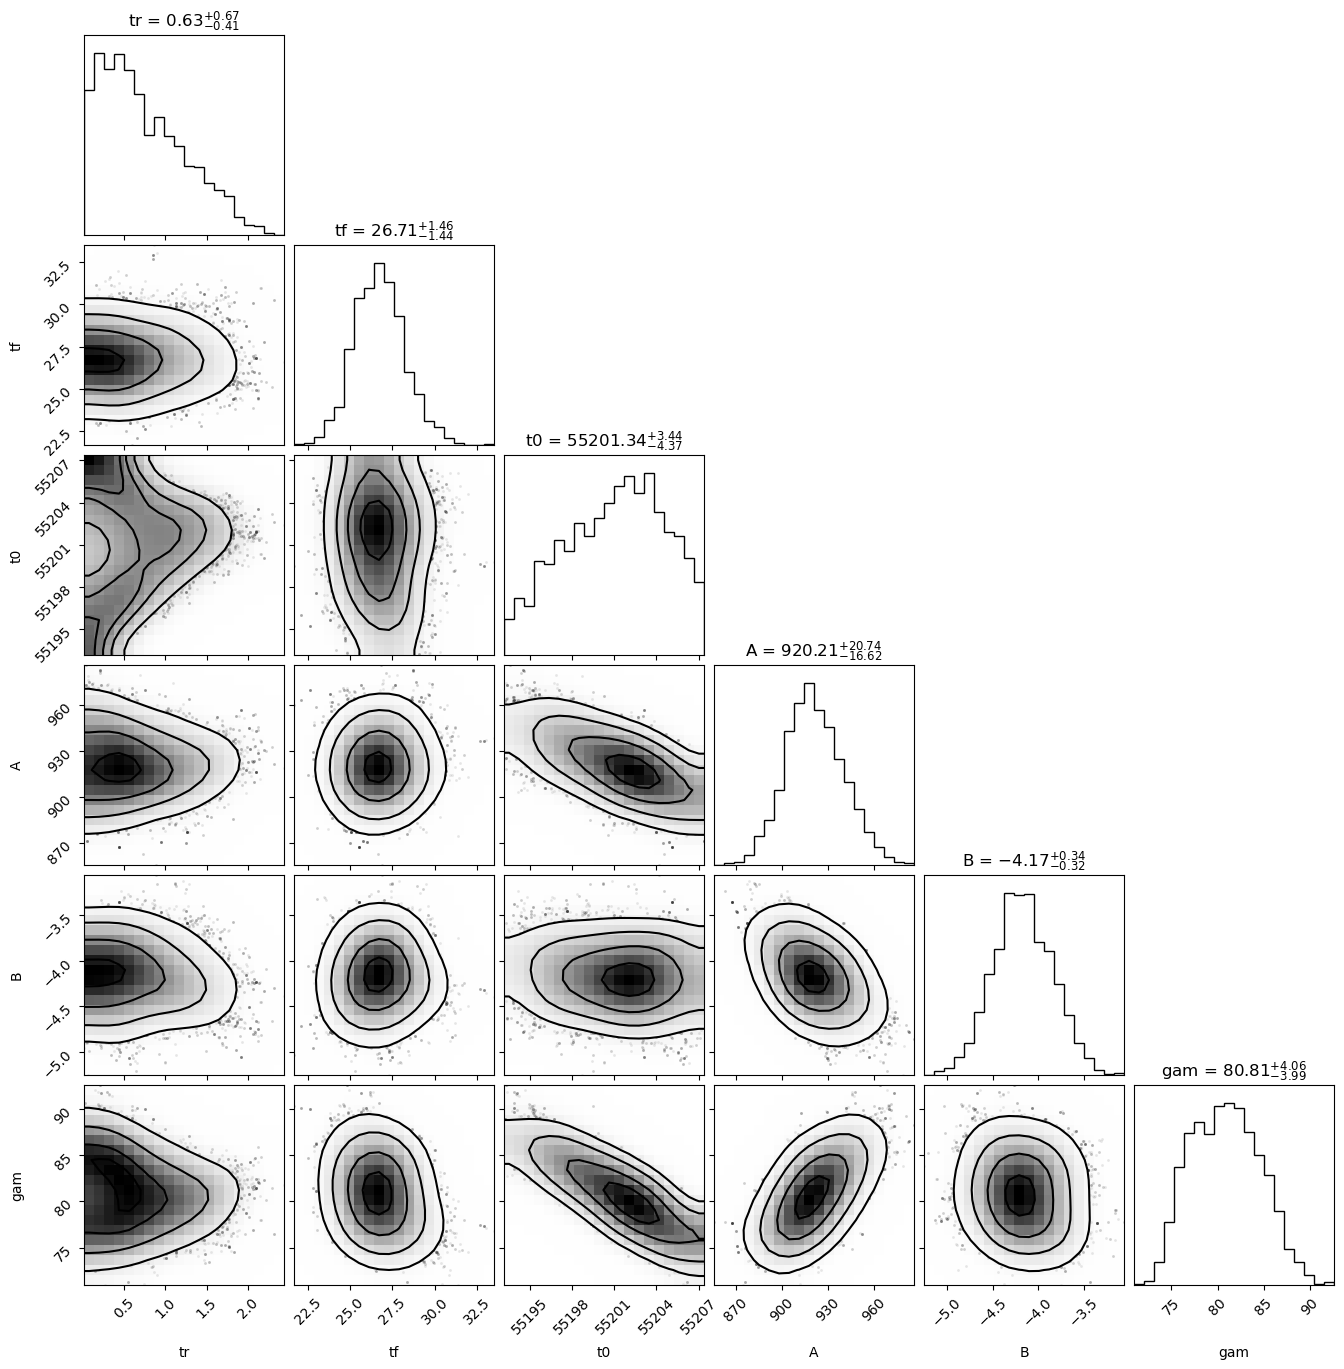

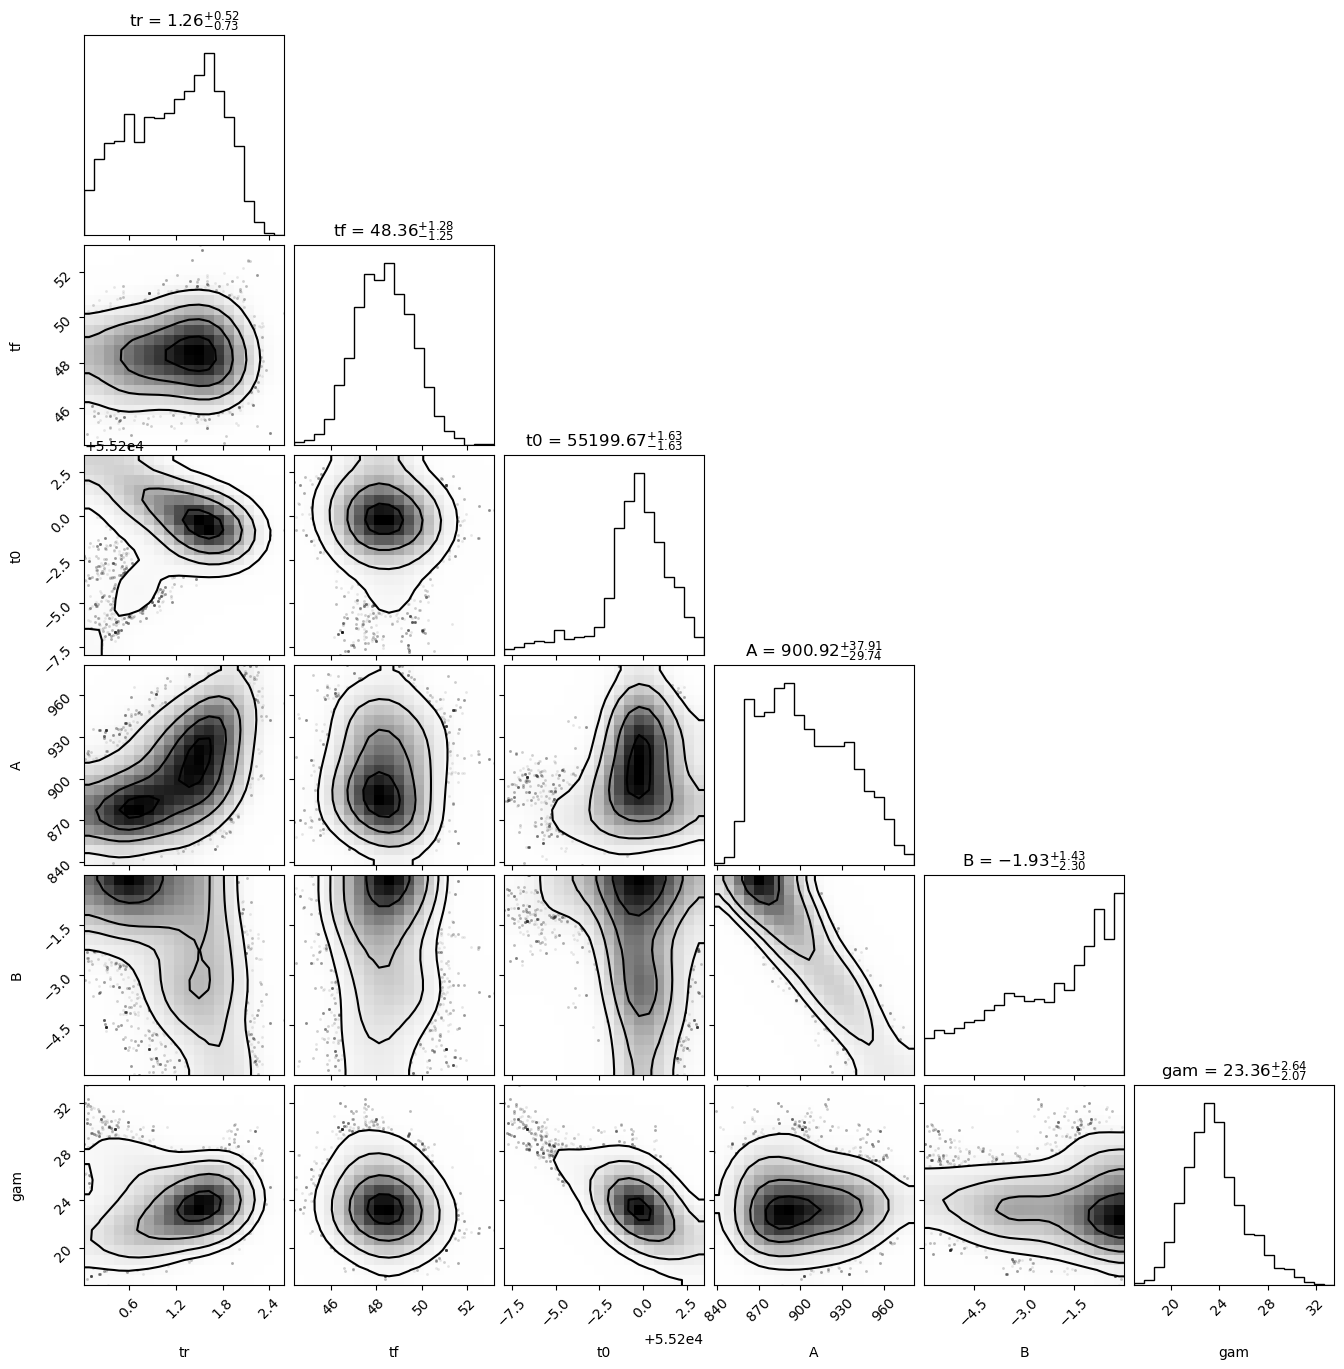

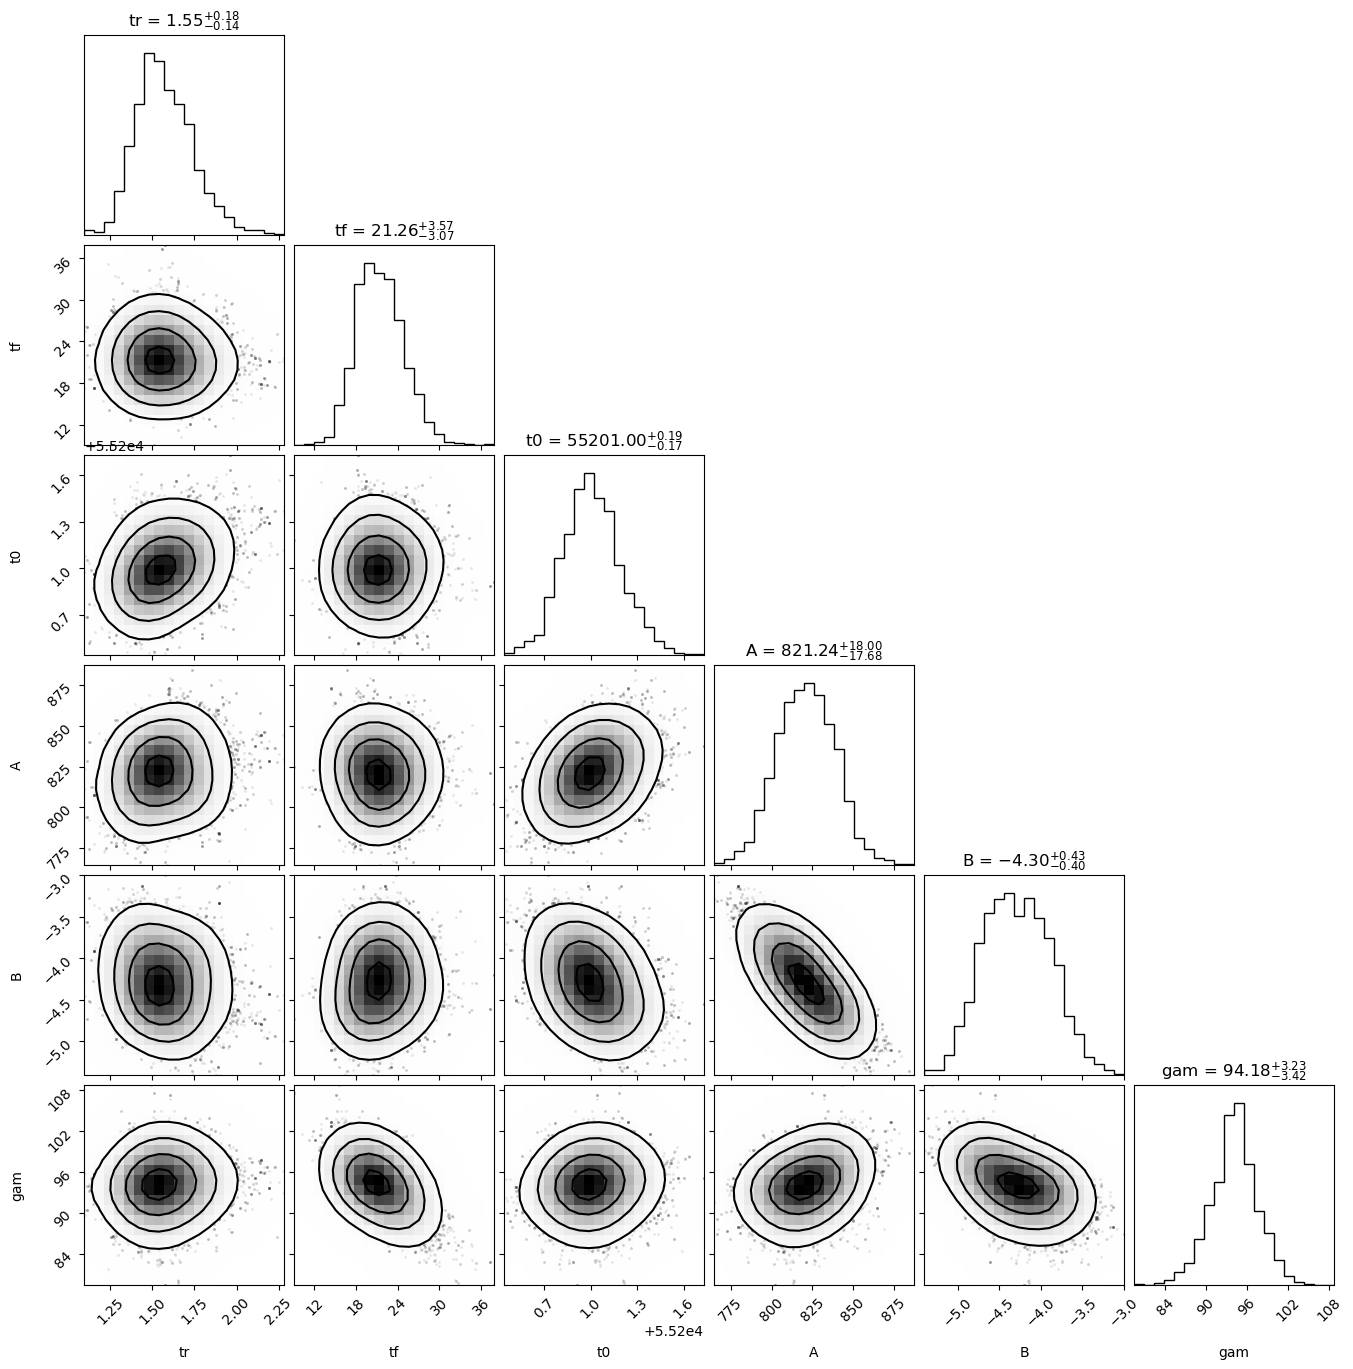

In [266]:
main(file1,guess1)

/tmp/ipykernel_14835/3402043166.py:53: RuntimeWarning: overflow encountered in exp
  den1 = (1+np.exp(-(t[maskA]-t0)/tr))
/tmp/ipykernel_14835/3402043166.py:54: RuntimeWarning: overflow encountered in exp
  den2 = (1+np.exp(-(t[~maskA]-t0)/tr))
/tmp/ipykernel_14835/3402043166.py:63: RuntimeWarning: overflow encountered in square
  lnL = ((flux - mod)**2.)/(2*e**2.)
/tmp/ipykernel_14835/3402043166.py:52: RuntimeWarning: overflow encountered in exp
  num2 = (A+B*gam)*np.exp(-(t[~maskA]-t1)/tf)
/tmp/ipykernel_14835/3402043166.py:52: RuntimeWarning: overflow encountered in multiply
  num2 = (A+B*gam)*np.exp(-(t[~maskA]-t1)/tf)
You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the g-band paramters with no lag is 0.016195760945022546.
The average auto correlation for the g-band paramters with a lag of 10 is 0.021928089030405575.


You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the i-band paramters with no lag is 0.011572489071588074.
The average auto correlation for the i-band paramters with a lag of 10 is 0.01634653429543111.


You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the r-band paramters with no lag is 0.03152747375244531.
The average auto correlation for the r-band paramters with a lag of 10 is -0.019438899954968485.


/tmp/ipykernel_14835/3402043166.py:56: RuntimeWarning: invalid value encountered in divide
  output[~maskA] = num2/den2
You must install the tqdm library to use progress indicators with emcee


The average auto correlation for the z-band paramters with no lag is 0.007026245845082088.
The average auto correlation for the z-band paramters with a lag of 10 is -0.008882603762122618.


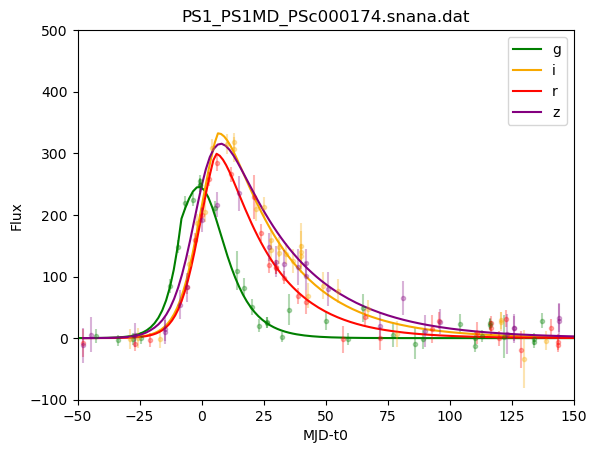

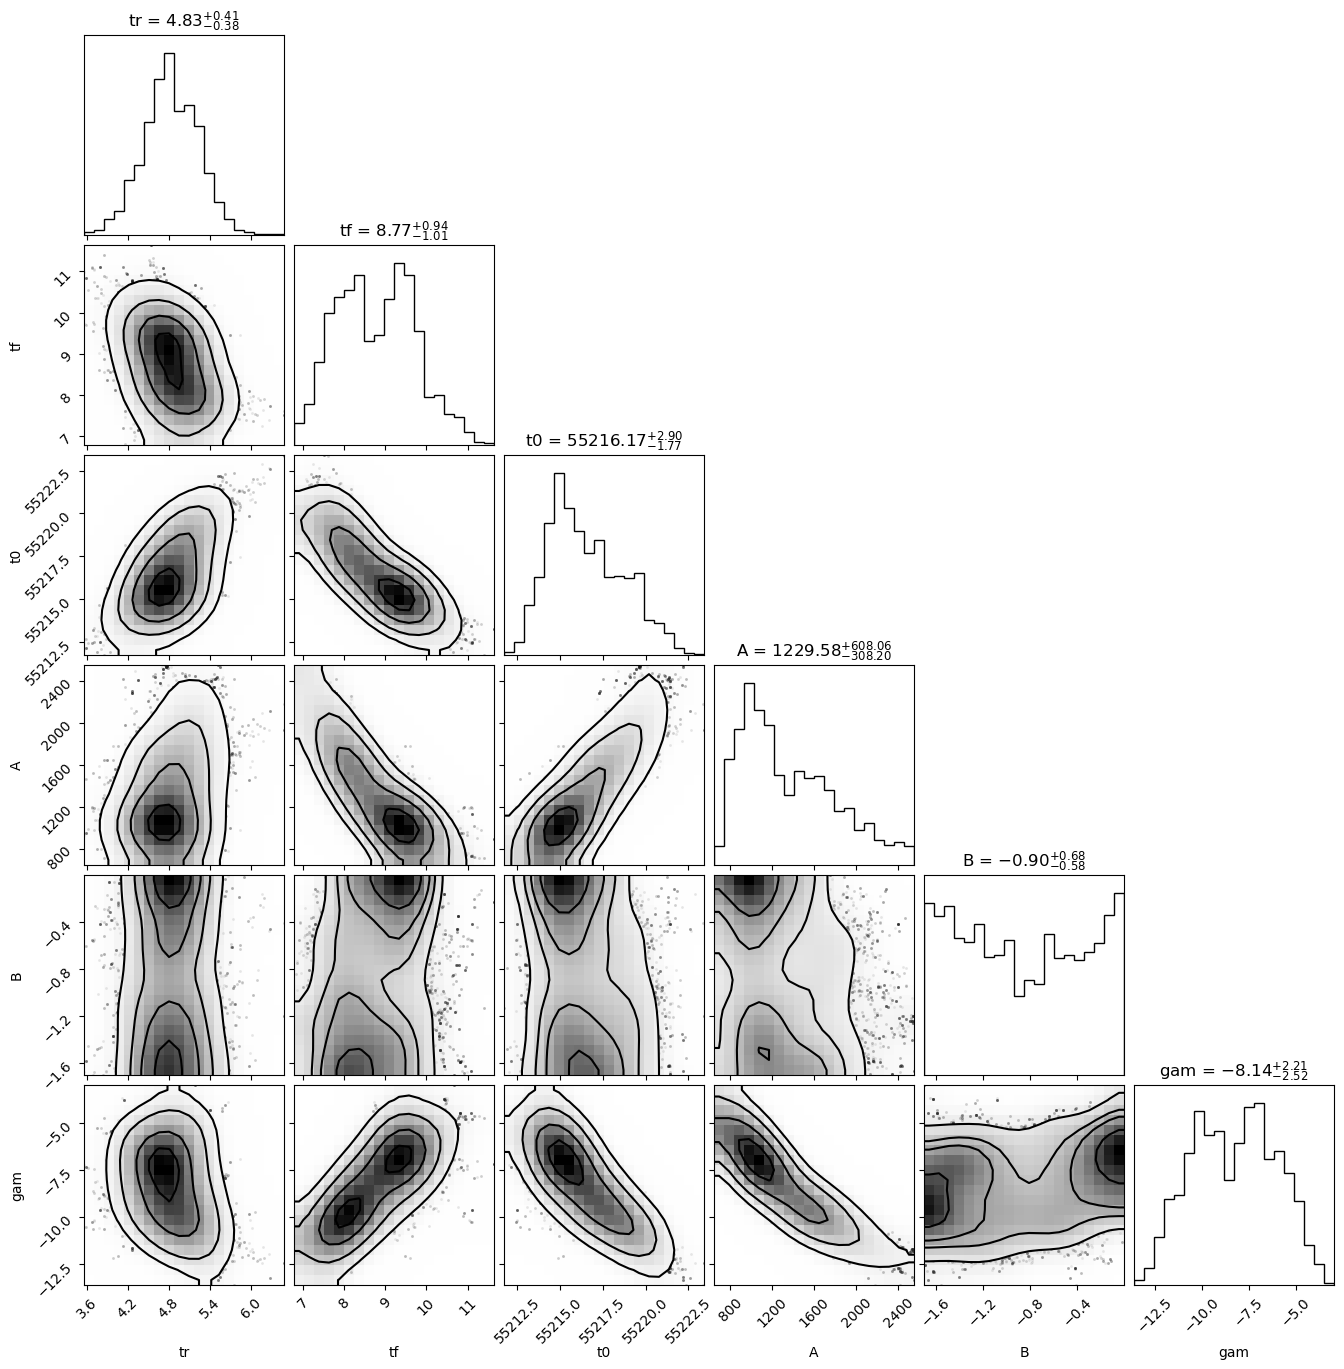

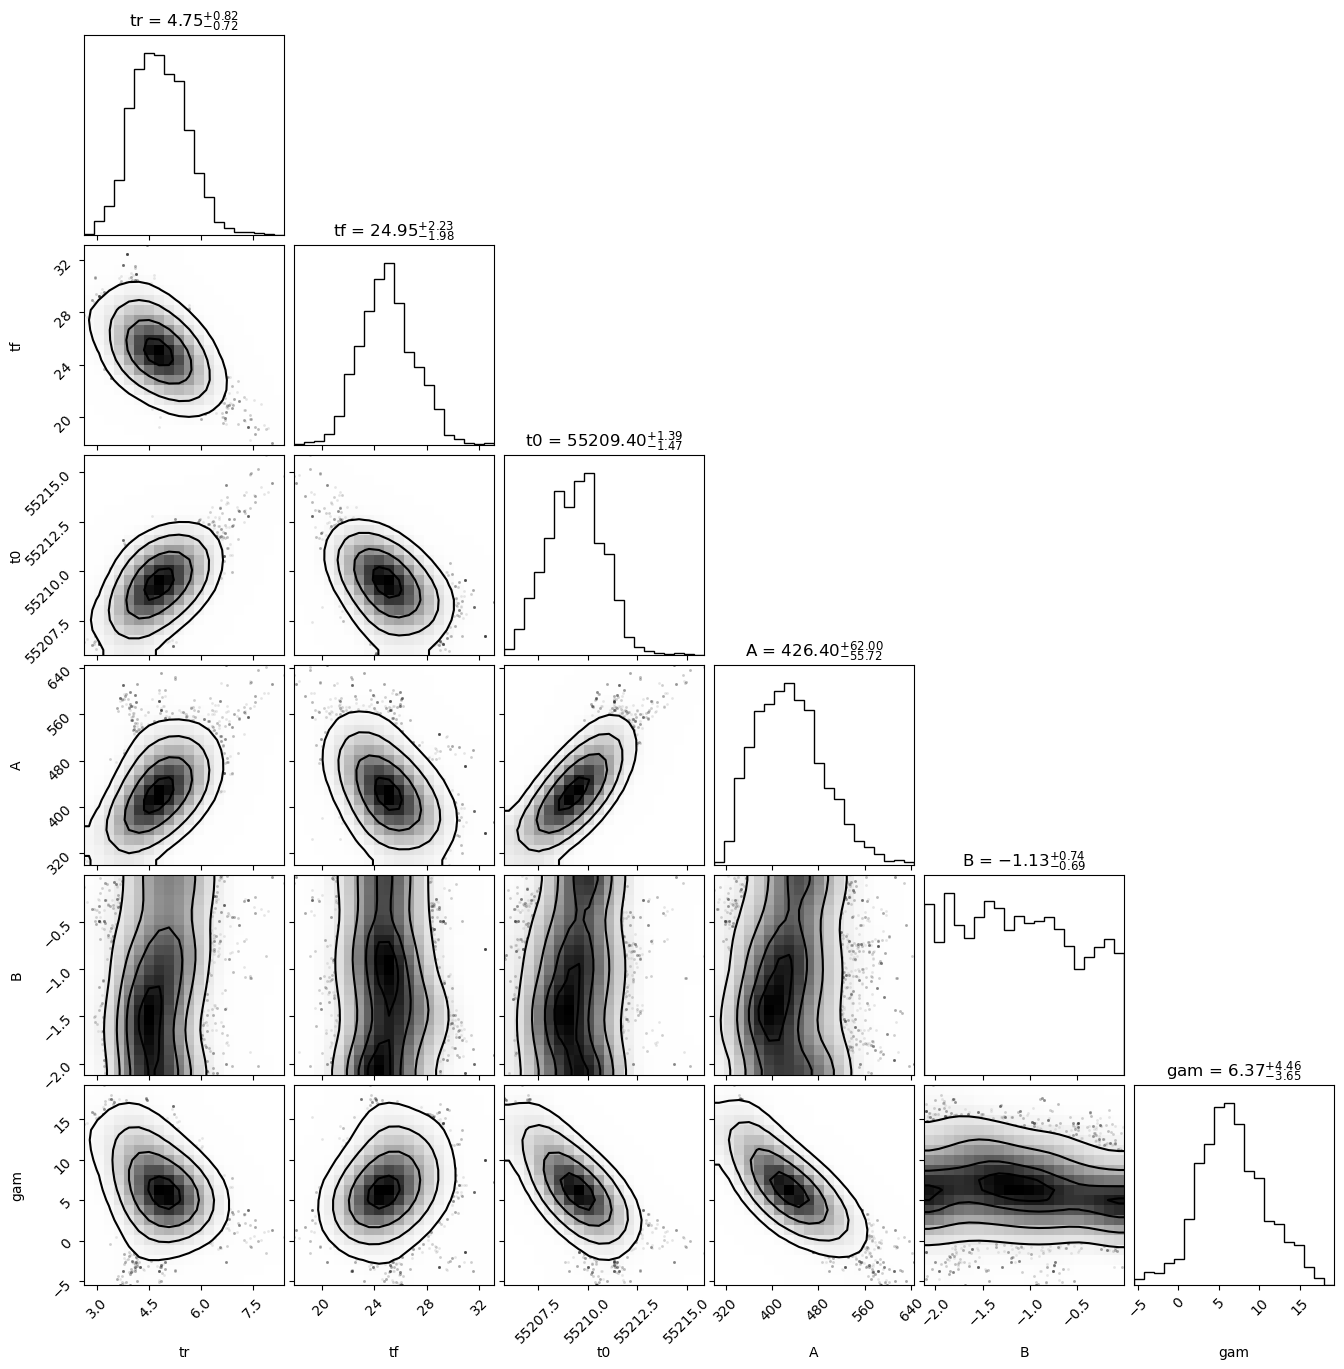

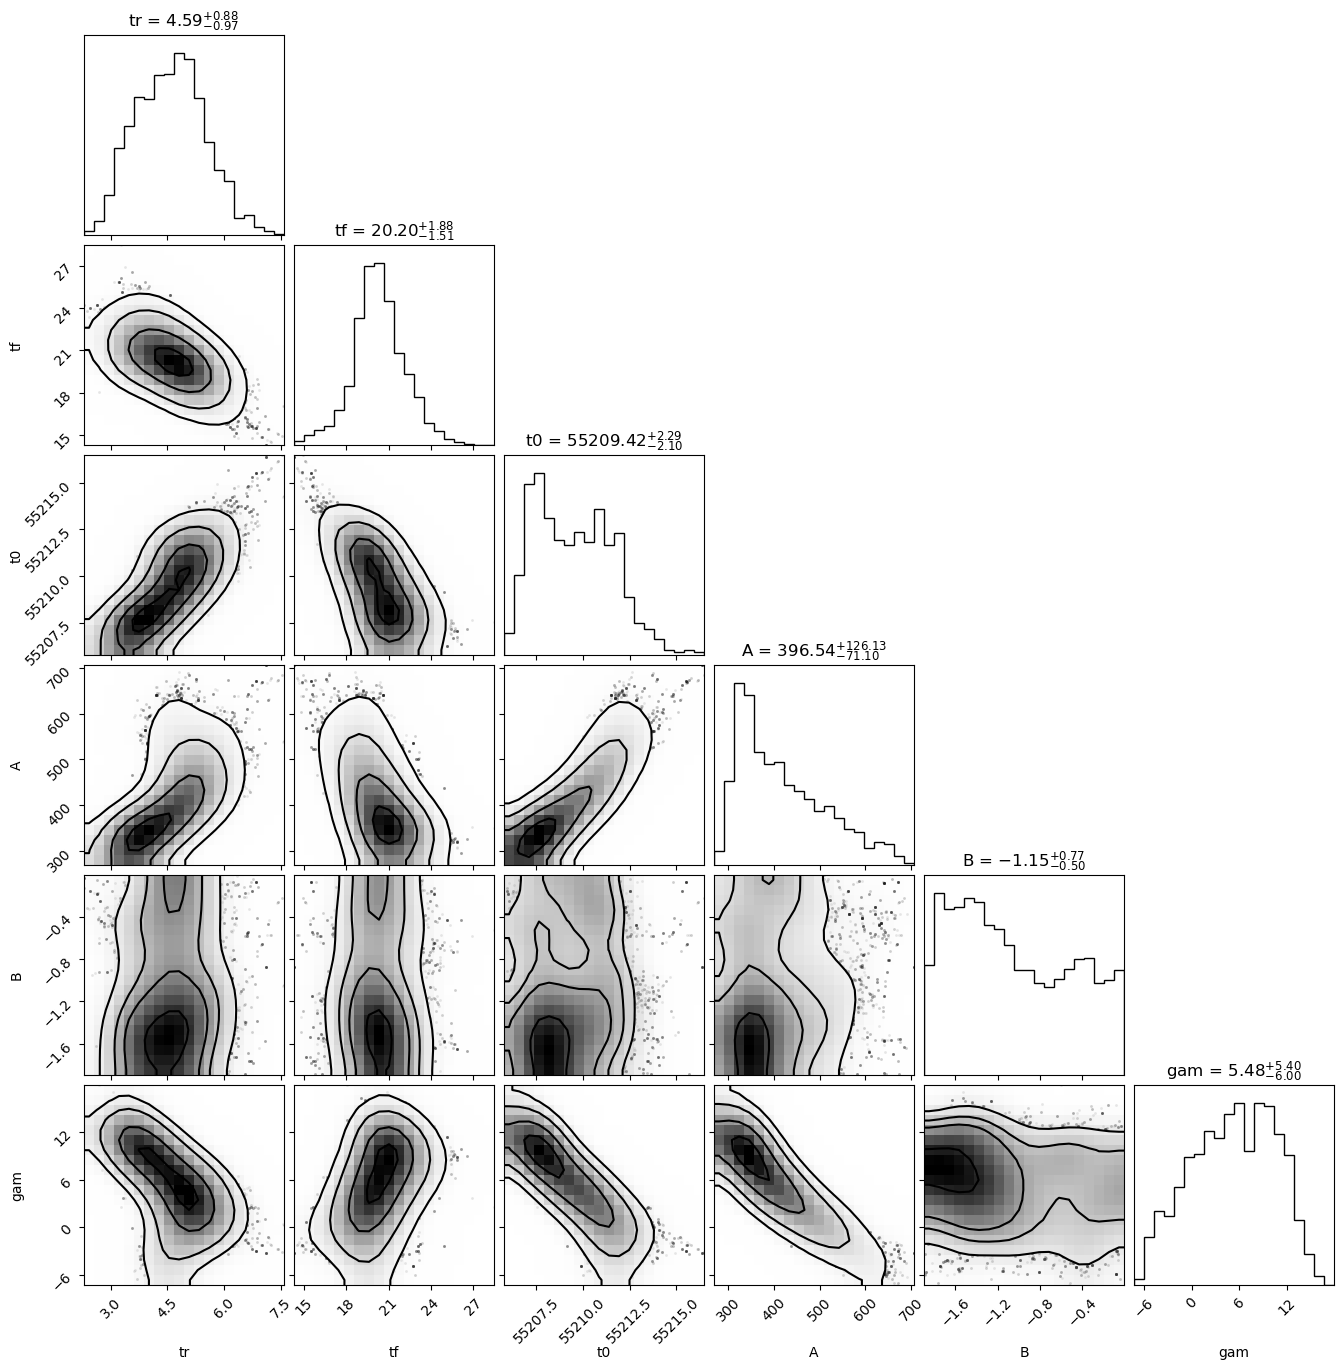

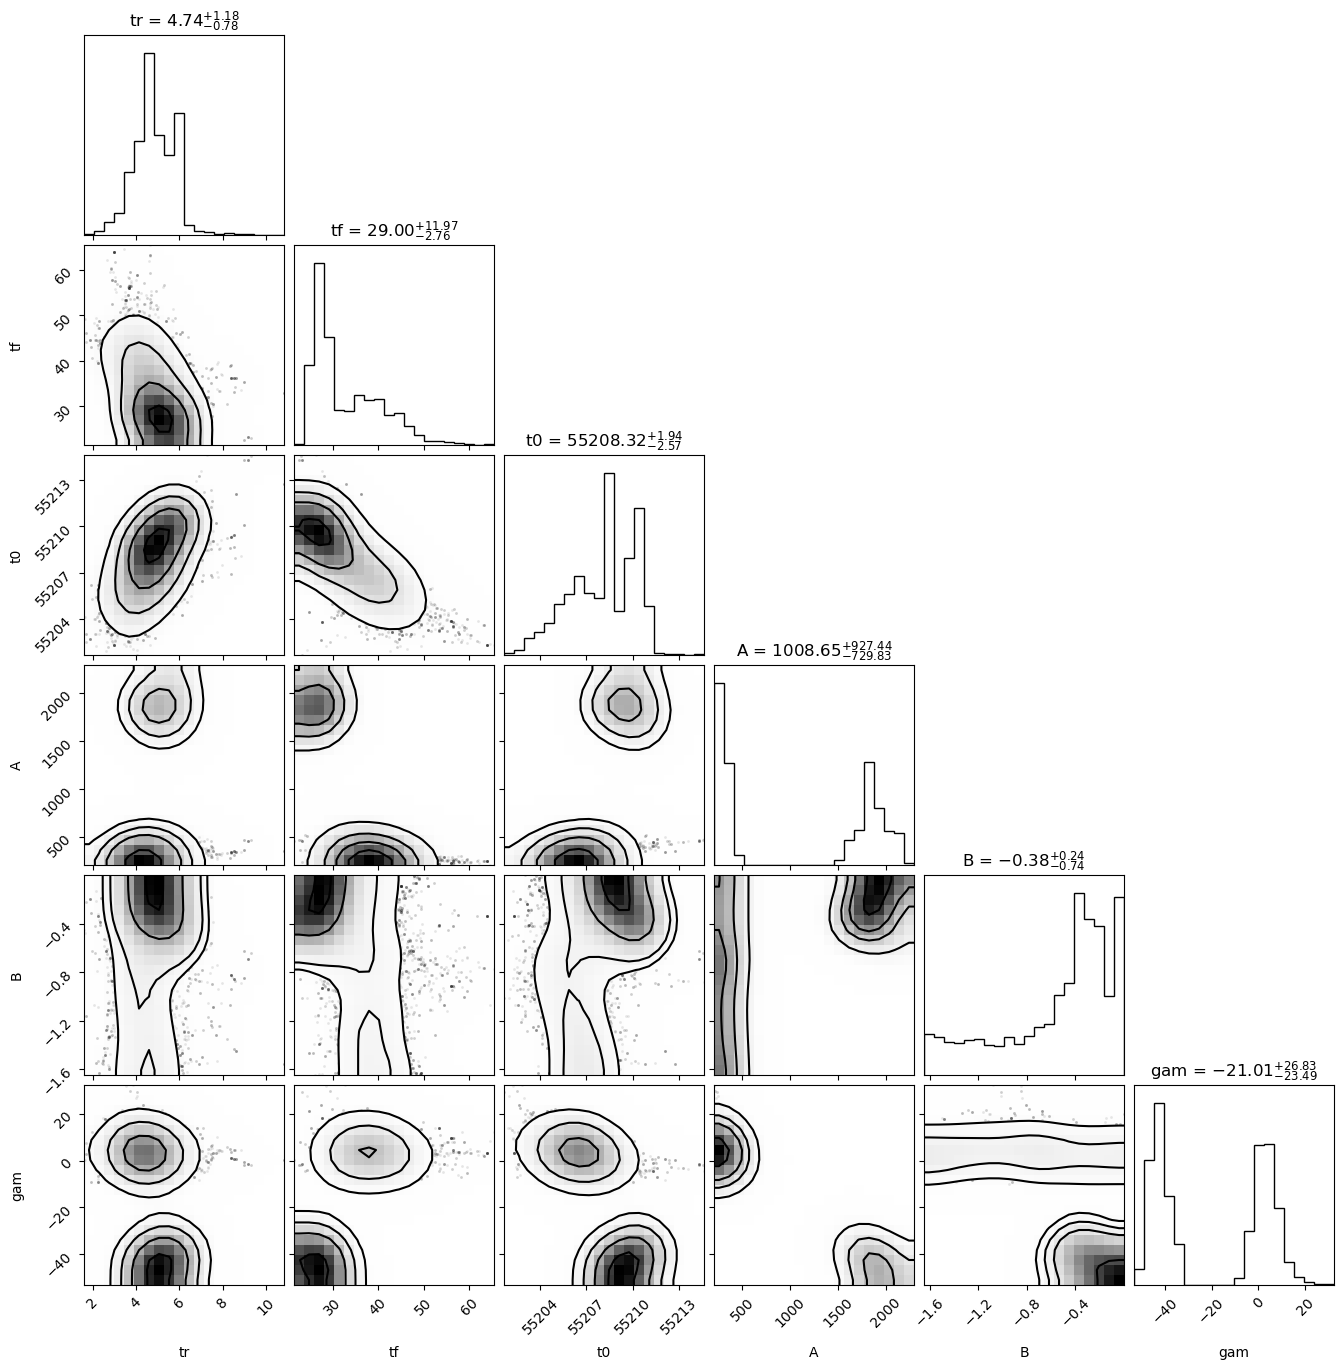

In [269]:
main(file2,guess2)